In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

/home/kushashwa/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
num_inputs = 2
num_neurons = 3

In [4]:
x0 = tf.placeholder(tf.float32, [None, num_inputs])
x1 = tf.placeholder(tf.float32, [None, num_inputs])

In [5]:
Wx = tf.random_normal(shape=[num_inputs, num_neurons])
Wy = tf.random_normal(shape=[num_neurons, num_neurons])
b = tf.zeros([1, num_neurons])

In [6]:
# graphs
y0 = tf.tanh(tf.matmul(x0, Wx) + b)
# feedback + present
y1 = tf.tanh(tf.matmul(y0, Wy) + tf.matmul(x1, Wx) + b)

In [7]:
# intialize variables
init = tf.global_variables_initializer()

In [8]:
# create data
# time stamp at t = 0
x0_batch = np.array([ [0, 1], [2, 3], [4, 5] ])
# time stamp at t = t + 1 = 1
x1_batch = np.array([ [100, 101], [102, 103], [104, 105] ])

In [9]:
with tf.Session() as sess:
    sess.run(init)
    
    y0_output_vals, y1_output_vals = sess.run([y0, y1], 
                    feed_dict = {x0:x0_batch, x1:x1_batch})

In [10]:
y0_output_vals

array([[ 0.46511364, -0.921773  ,  0.9284943 ],
       [ 0.96557266, -0.9307549 ,  0.9783266 ],
       [ 0.9983207 , -0.93873835,  0.993547  ]], dtype=float32)

In [11]:
y1_output_vals

array([[ 1.        , -0.99936646,  1.        ],
       [ 1.        , -0.9977223 ,  1.        ],
       [ 1.        , -0.99780226,  1.        ]], dtype=float32)

## Vanishing Gradients

While backpropagating, in deeper networks, gradients get smaller and at some point, they stop changing significantly.

GRU and LSTM can be used to fix them (in RNN)

**Depends on activation function choice.**

Like **sigmoid:** $$\sigma(z) = \cfrac{1}{1 + e^{-z}}$$

It saturates both <strong>positive and negative</strong> values.

**Solution:**

Use **ReLU** (doesn't saturate <strong>positive</strong> values.) Problem: for -ve numbers, always 0.

**Solution:**

Use **Leaky ReLU.**

Others: **ELU** (Exponential Linear Unit)

**Another solution: Use Batch Normalization, Gradient Clipping (cut off gradients to be b/w -1 and 1  : example)**

## Introduction to RNN using TF API

**Problem:** Time series.
($sin(t)$, t = time)

In [30]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
class TimeSeriesData():
    def __init__(self, num_points, xmin, xmax):
        # creates data
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (self.xmax - self.xmin)/(self.num_points)
        self.x_data = np.linspace(self.xmin, self.xmax, self.num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        # grab random starting point for each batch
        rand_start = np.random.rand(batch_size, 1)
        # convert to be on time series
        ts_start = rand_start * (self.xmax - self.xmin - \
                                (steps * self.resolution))
        # create batch series : x axis
        batch_ts = ts_start + np.arange(0.0, steps + 1) * \
        self.resolution
        # create y data for each x axis point
        y_batch = np.sin(batch_ts)
        # formatting for RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1), \
        y_batch[:, 1:].reshape(-1, steps, 1), batch_ts
        else:
            # returns at t = t and t = t + 1
            return y_batch[:, :-1].reshape(-1, steps, 1), \
        y_batch[:, 1:].reshape(-1, steps, 1)

In [18]:

ts_data = TimeSeriesData(250, 0, 10)

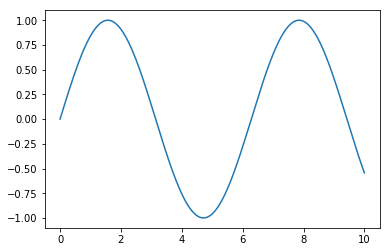

In [20]:
plt.plot(ts_data.x_data, ts_data.y_true)

In [21]:
num_timesteps = 30 # number of steps in each batch

In [40]:
def generateNextBatch(num_timesteps):
    y1, y2, ts = ts_data.next_batch(1, num_timesteps, True)
    return y1, y2, ts

In [28]:
ts.shape
# needs to be flattened

(1, 30, 1)

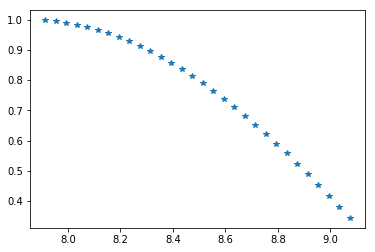

In [31]:
plt.plot(ts.flatten()[1:], y2.flatten(), '*')

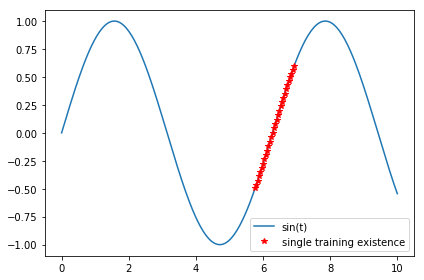

In [42]:
y1, y2, ts = generateNextBatch(30)
plt.plot(ts_data.x_data, ts_data.y_true, label='sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), '*', c = 'r', label='single training existence')
plt.legend()
plt.tight_layout()

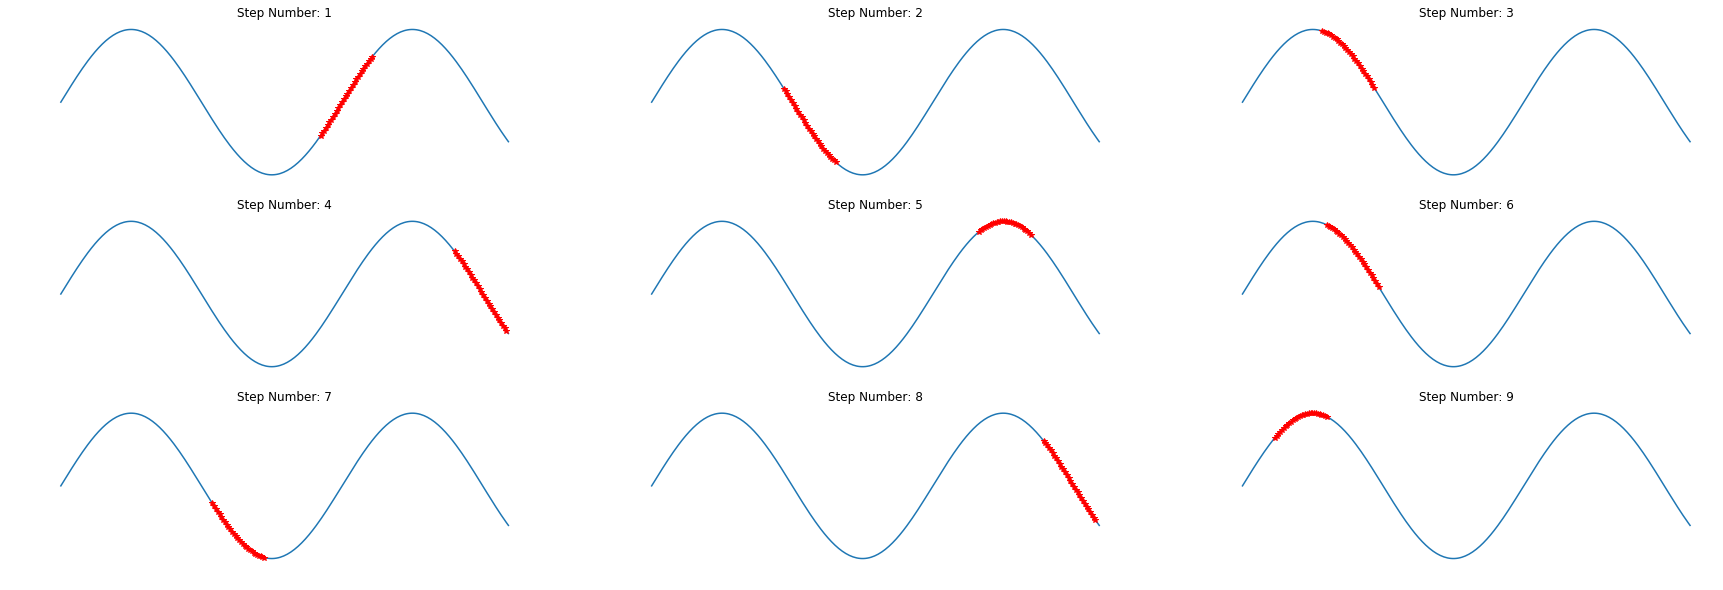

In [76]:
import math

plt.figure(figsize=[30,10]) 
num_cols = 3
num_images = 9
num_rows = math.ceil(num_images / num_cols)

for i in range(0, num_images):
    plt.subplot(num_rows, num_cols, i+1) 
    plt.axis('off')
    y1, y2, ts = generateNextBatch(30)
    plt.plot(ts_data.x_data, ts_data.y_true, label='sin(t)')
    plt.plot(ts.flatten()[1:], y2.flatten(), '*', c = 'r', label='single training existence')
    plt.title("Step Number: " + str(i + 1))

In [56]:
train_instance = np.linspace(5, 5 + ts_data.resolution * \
                    (num_timesteps + 1), num_timesteps + 1)

In [57]:
train_instance

array([5.        , 5.04133333, 5.08266667, 5.124     , 5.16533333,
       5.20666667, 5.248     , 5.28933333, 5.33066667, 5.372     ,
       5.41333333, 5.45466667, 5.496     , 5.53733333, 5.57866667,
       5.62      , 5.66133333, 5.70266667, 5.744     , 5.78533333,
       5.82666667, 5.868     , 5.90933333, 5.95066667, 5.992     ,
       6.03333333, 6.07466667, 6.116     , 6.15733333, 6.19866667,
       6.24      ])

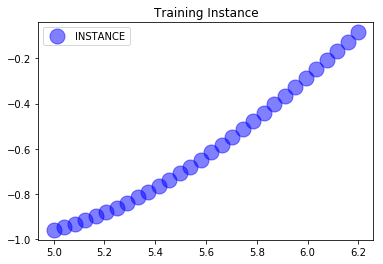

In [71]:
plt.title('Training Instance')

plt.plot(train_instance[:-1], ts_data.ret_true(train_instance[:-1]),
        'bo', markerSize=15, alpha=0.5, label='INSTANCE')

plt.legend()

We want to predict <strong>one time step</strong> ahead of it. \[Goal\]

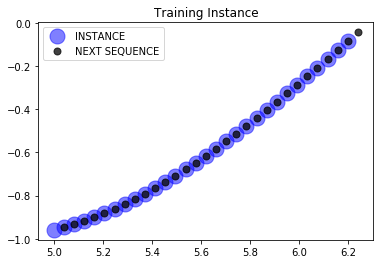

In [74]:
plt.title('Training Instance')

plt.plot(train_instance[:-1], ts_data.ret_true(train_instance[:-1]),
        'bo', markerSize=15, alpha=0.5, label='INSTANCE')
# doing for next time step (1: )
plt.plot(train_instance[1:], ts_data.ret_true(train_instance[1:]), 
        'ko', markerSize=7, alpha=0.75, label='NEXT SEQUENCE')

plt.legend()